In [121]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [122]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from matplotlib.pyplot import figure
from tqdm import tqdm


Task 1 section:
1. Estimate the high-frequency frequency of the increase in new cases of COVID disease ("Growth by days" graph)
2. Determine the dates corresponding to the highest points of each wave of incidence

In [123]:
df = pd.read_csv('/content/drive/MyDrive/tsa.csv',sep = ';', header = 0, decimal = ',')
df.shape

(1025, 4)

In [124]:
df.head()

,DateTime,Смертей за день,Заражений за день,Выздоровлений за день
0,2020-01-22 00:00:00,17,557,30.0
1,2020-01-23 00:00:00,1,100,2.0
2,2020-01-24 00:00:00,8,287,7.0
3,2020-01-25 00:00:00,16,493,3.0
4,2020-01-26 00:00:00,14,683,14.0


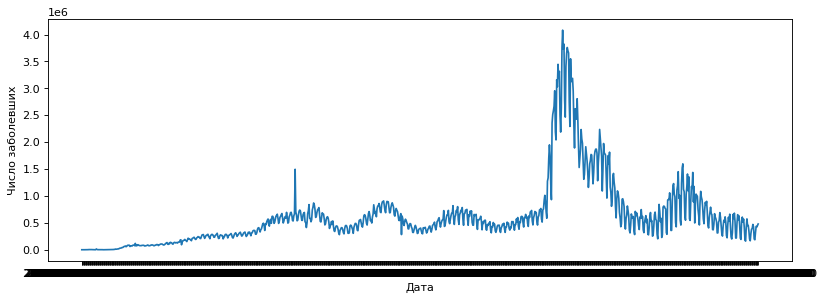

In [125]:
figure(figsize=(12, 4), dpi=80)
plt.plot(df.DateTime,df['Заражений за день'])
plt.xlabel('Дата')
plt.ylabel('Число заболевших');

high frequency vibrations:

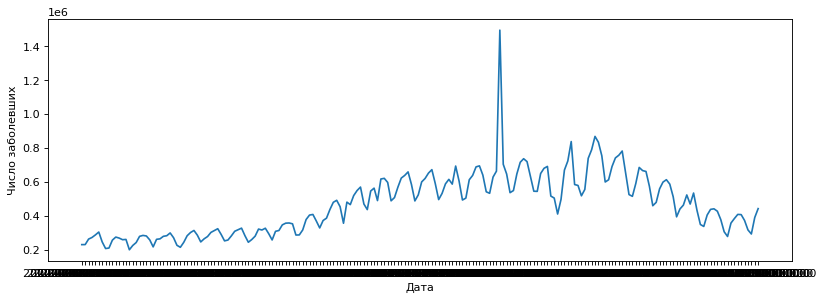

In [126]:
figure(figsize=(12,4), dpi=80)
plt.plot(df.DateTime[200:400],df['Заражений за день'][200:400])
plt.xlabel('Дата')
plt.ylabel('Число заболевших');

In [127]:
df.dtypes

DateTime                  object
Смертей за день            int64
Заражений за день          int64
Выздоровлений за день    float64
dtype: object

In [128]:
df['DateTime'] = pd.to_datetime(df['DateTime'])
Ts = np.mean(np.diff(df['DateTime'])) / np.timedelta64(1, 's')
Ts

86400.0

Find the sample rate of the data in HZ

In [129]:
Fs = 1 / Ts
Fs

1.1574074074074073e-05

In [130]:
znach = []
for i in range(df.shape[0]):
      znach.append(i*Ts)
len(znach)

1025

In [131]:
df['seconds'] = znach

In [132]:
df.head()

,DateTime,Смертей за день,Заражений за день,Выздоровлений за день,seconds
0,2020-01-22,17,557,30.0,0.0
1,2020-01-23,1,100,2.0,86400.0
2,2020-01-24,8,287,7.0,172800.0
3,2020-01-25,16,493,3.0,259200.0
4,2020-01-26,14,683,14.0,345600.0


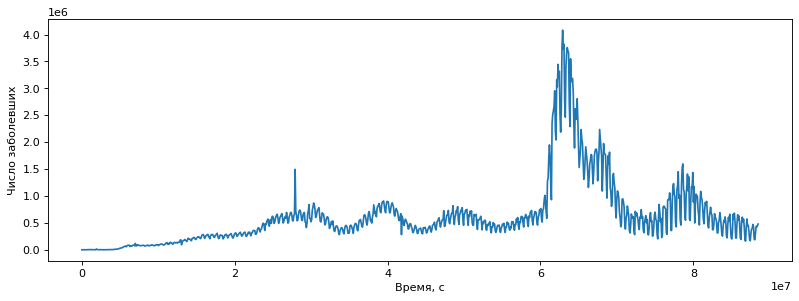

In [133]:
figure(figsize=(12, 4), dpi=80)
plt.plot(df.seconds,df['Заражений за день']);
plt.xlabel('Время, с')
plt.ylabel('Число заболевших');

direct Fourier transform

In [134]:
otch = np.fft.fft(df['Заражений за день'])
f =[]
for i in range(len(znach)):
    f.append(Fs * i / len(znach))

Let's build a graph of the spectral density of the signal

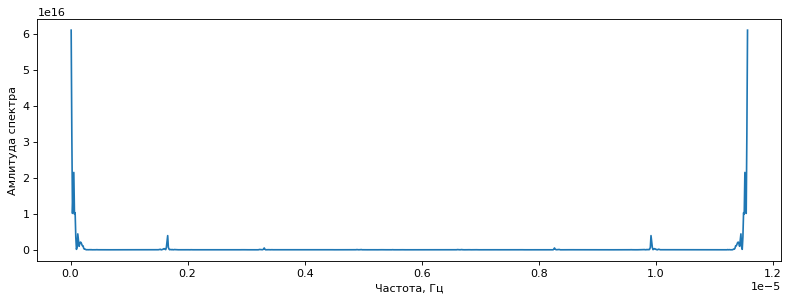

In [135]:
figure(figsize=(12, 4), dpi=80)
plt.plot(f[1:],(abs(otch)**2)[1:])
plt.xlabel('Частота, Гц')
plt.ylabel('Амлитуда спектра');

Let's determine which frequencies have a significant contribution, that is, they carry high energy in the original signal

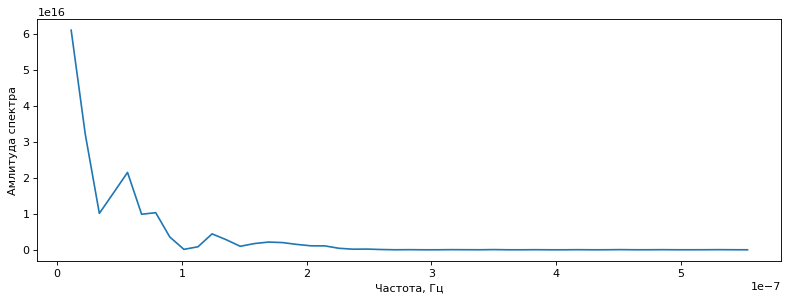

In [136]:
figure(figsize=(12, 4), dpi=80)
plt.plot(f[1:50],(abs(otch)**2)[1:50])
plt.xlabel('Частота, Гц')
plt.ylabel('Амлитуда спектра');

The frequency of fluctuations is more than 0.25 μHz - Caused by the frequency of entry in the register and other accidents. Informative changes occur at intervals of more than 46 days

In [137]:
print(str(int(1/(25*10**-8)/(60*60*24))),'дней')

46 дней


Let us expand the original function in a Fourier series

In [138]:
otch = np.fft.fft(df['Заражений за день'])
re = otch.real
im = otch.imag
amp = np.zeros(len(znach))
for garmonica in range(int(len(znach)/2)):
    for t in range(len(znach)):
        amp[t] = amp[t] + ((1 / len(otch)) * (abs(otch[garmonica]) * np.cos(2 * np.pi / len(znach) * garmonica * t  + 
                                                                            np.angle(otch[garmonica]))))

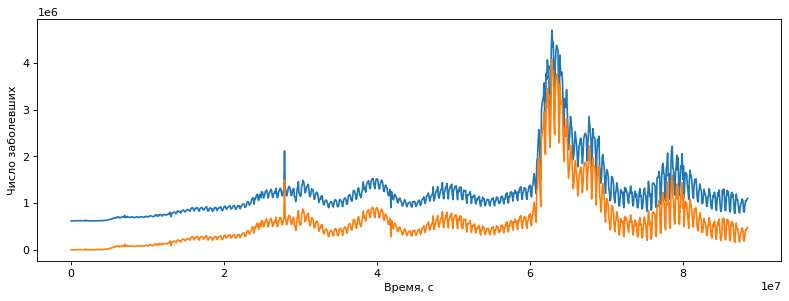

In [139]:
figure(figsize=(12, 4), dpi=80)
plt.plot(df.seconds,amp*2)
plt.plot(df.seconds,df['Заражений за день'])
plt.xlabel('Время, с')
plt.ylabel('Число заболевших');

Let's limit the number of harmonics and see how the signal is restored with an increase in their number.

100%|██████████| 5/5 [00:00<00:00, 15.28it/s]


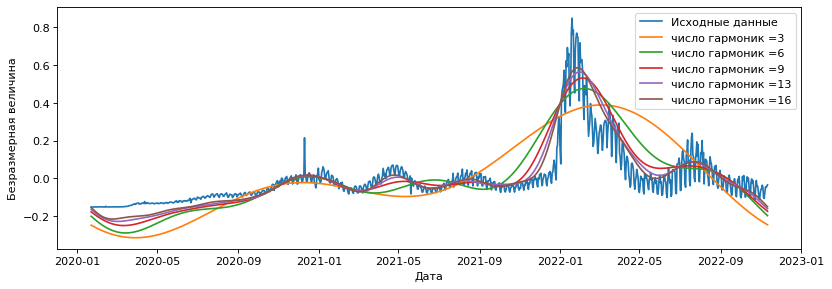

In [140]:
figure(figsize=(12, 4), dpi=80)
inf = df['Заражений за день']
plt.plot(df.DateTime,(inf-inf.mean())/max(inf),label='Исходные данные')
plt.xlabel('Дата')
plt.ylabel('Безразмерная величина');
amp = np.zeros(len(znach))
for j in tqdm(np.linspace(3, int(len(znach)/50), 5, endpoint=False)):
    for garmonica in range(int(j)):
        for t in range(len(znach)):
            amp[t] = amp[t] + ((1 / len(otch)) * (abs(otch[garmonica]) * np.cos(2 * np.pi / len(znach) * garmonica * t  + 
                                                                                np.angle(otch[garmonica]))))
    text = 'число гармоник ='+ str(int(j))
    plt.plot(df.DateTime,(amp-amp.mean())/max(amp), label=text)
plt.legend();

Without filters, in order to find the maxima for each of the waves of the coronavirus, it is necessary to approximate the signal with a set of trigonometric functions. This is ideally handled by the expansion in a Fourier series. Let's limit the number of harmonics to eight.

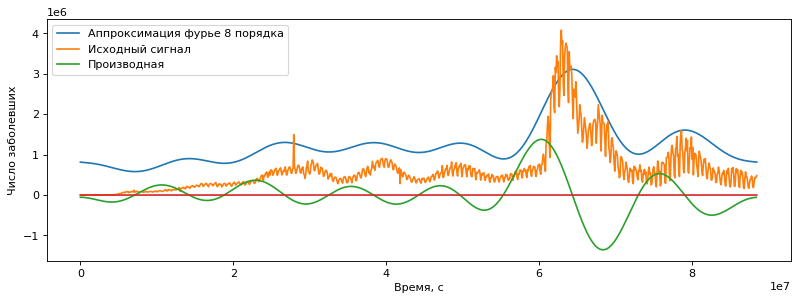

In [141]:
figure(figsize=(12, 4), dpi=80)
amp = np.zeros(len(znach))
for garmonica in range(8):
    for t in range(len(znach)):
        amp[t] = amp[t] + ((1 / len(otch)) * (abs(otch[garmonica]) * np.cos(2 * np.pi / len(znach) * garmonica * t  + 
                                                                            np.angle(otch[garmonica]))))
plt.plot(df.seconds, amp*2, label='Аппроксимация фурье 8 порядка')
plt.plot(df.seconds,df['Заражений за день'], label='Исходный сигнал')
plt.plot(df.seconds[:-1], np.diff(amp)*80, label='Производная')
plt.plot(df.seconds, np.zeros(len(amp)))
plt.xlabel('Время, с')
plt.ylabel('Число заболевших')
plt.legend();

The next goal is to find the maximums. This can be done using the derivative and further selection of suitable local extrema

In [142]:
dif = np.diff(amp)

In [143]:
waves_max = []
waves_num = []
print('Дни пиков заражаемости в волнах:')
for i in range(1, len(dif)-1):
    if (abs(dif[i-1]) > abs(dif[i])) & (abs(dif[i+1]) > abs(dif[i])) & (dif[i-1] > 0) & (dif[i+1] < 0):
        print(df.DateTime[i])
        waves_max.append(df.DateTime[i])
        waves_num.append(i)

Дни пиков заражаемости в волнах:
2020-07-04 00:00:00
2020-11-26 00:00:00
2021-04-10 00:00:00
2021-08-19 00:00:00
2022-02-05 00:00:00
2022-07-25 00:00:00


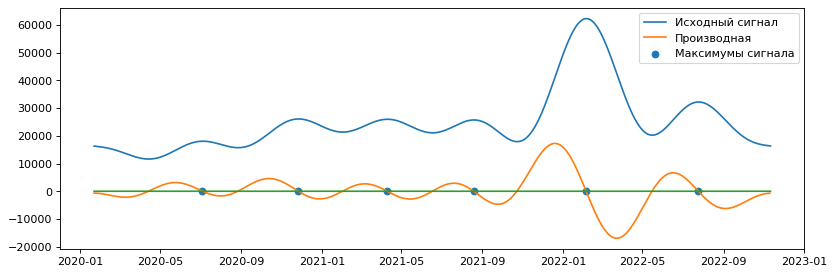

In [144]:
dif = np.diff(amp)
figure(figsize=(12, 4), dpi=80)
plt.plot(df.DateTime, amp*0.04, label='Исходный сигнал')
plt.plot(df.DateTime[:-1], np.diff(amp), label='Производная')
plt.plot(df.DateTime, np.zeros(len(amp)))
plt.scatter(waves_max, np.zeros(len(waves_max)), label='Максимумы сигнала')
plt.legend();


In [145]:
print('Число волн равяется', len(waves_max))

Число волн равяется 6


Let's display information on statistics on the days of maximum infections for each of the waves

In [146]:
df.query('DateTime in @waves_max')

,DateTime,Смертей за день,Заражений за день,Выздоровлений за день,seconds
164,2020-07-04,4793,189705,195760.0,14169600.0
309,2020-11-26,10935,589033,366876.0,26697600.0
444,2021-04-10,13008,670625,384994.0,38361600.0
575,2021-08-19,11453,711636,NaN,49680000.0
745,2022-02-05,8383,2315870,NaN,64368000.0
915,2022-07-25,2021,1026835,NaN,79056000.0
